In [1]:
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization, Activation, add
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import keras.backend as K
from sklearn.metrics import explained_variance_score, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/tambet/.conda/envs/pommer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# make sure TF does not allocate all memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [3]:
data = np.load('single_600K_disc0.9.npz')
x_train = data['observations']
p_train = data['actions']
v_train = data['rewards']
x_train.shape, p_train.shape, v_train.shape

((600000, 11, 11, 18), (600000,), (600000,))

In [4]:
data = np.load('valid_single_80K_disc0.9.npz')
x_test = data['observations']
p_test = data['actions']
v_test = data['rewards']
x_test.shape, p_test.shape, v_test.shape

((80000, 11, 11, 18), (80000,), (80000,))

In [5]:
def ConvBlock(mod):
    mod = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    return mod

def ResidualBlock(mod):
    tmp = mod
    mod = ConvBlock(mod)
    mod = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = add([mod,tmp])
    mod = Activation('relu')(mod)
    return mod

def PolicyHead(mod):
    mod = Conv2D(filters=2, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(6, activation='softmax', name='p')(mod)
    return mod

def ValueHead(mod):
    mod = Conv2D(filters=1, kernel_size=1, strides=1, padding="same")(mod)
    mod = BatchNormalization()(mod)
    mod = Activation('relu')(mod)
    mod = Flatten()(mod)
    mod = Dense(256)(mod)
    mod = Activation('relu')(mod)
    mod = Dense(1)(mod)
    mod = Activation('tanh',name='v')(mod)
    return mod

h = x = Input(shape=(11,11,18))
h = ConvBlock(h)
for i in range(20):
    h = ResidualBlock(h)
p = PolicyHead(h)
v = ValueHead(h)
model = Model(x, [p, v])
model.summary()
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'mse'], loss_weights=[1, 10], metrics={'p': 'accuracy'})

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 11, 11, 18)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 64)   10432       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11, 11, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 11, 11, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
callbacks = [
    ModelCheckpoint('agz20x64_single_value10_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
]

In [7]:
history = model.fit(x_train, [p_train, v_train], batch_size=256, epochs=100, validation_data=(x_test, [p_test, v_test]), callbacks=callbacks)

Train on 600000 samples, validate on 80000 samples
Epoch 1/100
600000/600000 [==============================] - 1347s 2ms/step - loss: 1.2955 - p_loss: 0.9926 - v_loss: 0.0303 - p_acc: 0.5783 - val_loss: 0.9113 - val_p_loss: 0.6610 - val_v_loss: 0.0250 - val_p_acc: 0.7159

Epoch 00001: val_loss improved from inf to 0.91132, saving model to agz20x64_single_value10_best.h5
Epoch 2/100
409600/600000 [===================>..........] - ETA: 6:47 - loss: 0.8142 - p_loss: 0.5825 - v_loss: 0.0232 - p_acc: 0.7336

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600000/600000 [==============================] - 1355s 2ms/step - loss: 0.6860 - p_loss: 0.4839 - v_loss: 0.0202 - p_acc: 0.7636 - val_loss: 0.7192 - val_p_loss: 0.4990 - val_v_loss: 0.0220 - val_p_acc: 0.7568

Epoch 00005: val_loss improved from 0.74380 to 0.71921, saving model to agz20x64_single_value10_best.h5
Epoch 6/100
600000/600000 [==============================] - 1331s 2ms/step - loss: 0.6675 - p_loss: 0.4740 - v_loss: 0.0193 - p_acc: 0.7669 - val_loss: 0.7011 - val_p_loss: 0.4868 - val_v_loss: 0.0214 - val_p_acc: 0.7614

Epoch 00006: val_loss improved from 0.71921 to 0.70107, saving model to agz20x64_single_value10_best.h5
Epoch 7/100
104704/600000 [====>.........................] - ETA: 17:13 - loss: 0.6534 - p_loss: 0.4647 - v_loss: 0.0189 - p_acc: 0.7709

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600000/600000 [==============================] - 1333s 2ms/step - loss: 0.6169 - p_loss: 0.4504 - v_loss: 0.0166 - p_acc: 0.7772 - val_loss: 0.6755 - val_p_loss: 0.4815 - val_v_loss: 0.0194 - val_p_acc: 0.7623

Epoch 00010: val_loss improved from 0.68644 to 0.67554, saving model to agz20x64_single_value10_best.h5
Epoch 11/100
600000/600000 [==============================] - 1338s 2ms/step - loss: 0.6077 - p_loss: 0.4461 - v_loss: 0.0162 - p_acc: 0.7795 - val_loss: 0.6891 - val_p_loss: 0.4886 - val_v_loss: 0.0200 - val_p_acc: 0.7609

Epoch 00011: val_loss did not improve from 0.67554
Epoch 12/100
600000/600000 [==============================] - 1336s 2ms/step - loss: 0.5979 - p_loss: 0.4422 - v_loss: 0.0156 - p_acc: 0.7819 - val_loss: 0.6691 - val_p_loss: 0.4742 - val_v_loss: 0.0195 - val_p_acc: 0.7639

Epoch 00012: val_loss improved from 0.67554 to 0.66911, saving model to agz20x64_single_value10_best.h5
Epoch 13/100
244992/600000 [===========>..................] - ETA: 12:21 - loss: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



600000/600000 [==============================] - 1320s 2ms/step - loss: 0.5674 - p_loss: 0.4285 - v_loss: 0.0139 - p_acc: 0.7905 - val_loss: 0.6872 - val_p_loss: 0.4857 - val_v_loss: 0.0202 - val_p_acc: 0.7638

Epoch 00015: val_loss did not improve from 0.66911
Epoch 16/100
600000/600000 [==============================] - 1327s 2ms/step - loss: 0.5569 - p_loss: 0.4237 - v_loss: 0.0133 - p_acc: 0.7932 - val_loss: 0.6962 - val_p_loss: 0.4884 - val_v_loss: 0.0208 - val_p_acc: 0.7607

Epoch 00016: val_loss did not improve from 0.66911
Epoch 17/100
600000/600000 [==============================] - 1325s 2ms/step - loss: 0.5466 - p_loss: 0.4177 - v_loss: 0.0129 - p_acc: 0.7973 - val_loss: 0.7101 - val_p_loss: 0.5026 - val_v_loss: 0.0207 - val_p_acc: 0.7635

Epoch 00017: val_loss did not improve from 0.66911
Epoch 00017: early stopping


Text(0.5,1,'Value MSE')

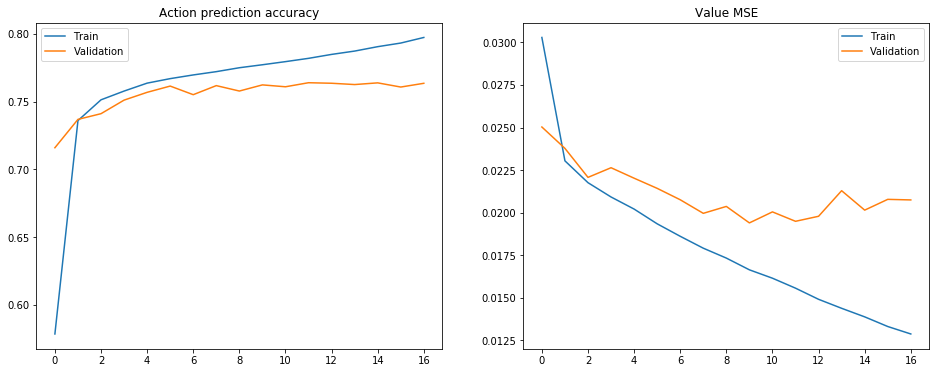

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['p_acc'])
plt.plot(history.history['val_p_acc'])
plt.legend(['Train', 'Validation'])
plt.title("Action prediction accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['v_loss'])
plt.plot(history.history['val_v_loss'])
plt.legend(['Train', 'Validation'])
plt.title("Value MSE")

In [9]:
model.save('agz20x64_single_value10_disc0.9_final.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.8024683333333333
Accuracy test: 0.763475
Explained variance train: 0.7644550062555506
Explained variance test: 0.6172544867321912


In [11]:
model = load_model('agz20x64_single_value10_disc0.9_best.h5')
p_train_pred, v_train_pred = model.predict(x_train, batch_size=2048)
p_test_pred, v_test_pred = model.predict(x_test)
act_train_pred = np.argmax(p_train_pred, axis=1)
act_test_pred = np.argmax(p_test_pred, axis=1)
print("Accuracy train:", accuracy_score(p_train, act_train_pred))
print("Accuracy test:", accuracy_score(p_test, act_test_pred))
print("Explained variance train:", explained_variance_score(v_train, v_train_pred))
print("Explained variance test:", explained_variance_score(v_test, v_test_pred))

Accuracy train: 0.7874233333333334
Accuracy test: 0.7639
Explained variance train: 0.7283068562840729
Explained variance test: 0.6422401192796809
